# Recreating Fig. 2

The paper [NOISE OR SIGNAL: THE ROLE OF IMAGE BACKGROUNDS IN OBJECT RECOGNITION](https://openreview.net/pdf?id=gl3D-xY7wLq) explores the effect of background on predictive deep learning models.


![title](Capture.png)

In this paper they show the following accuracies can be achieved on their models when training them on modified data then testing them on the original data. 

Our goal is to recreate these results

# 1. Setting up the data

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter
import torchvision.models as models

In [2]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
train = datasets.ImageFolder('data/no_fg/train', transform=transform)
test = datasets.ImageFolder('data/no_fg/val', transform=transform)

In [3]:
N = {"train" : len(train), "test" : len(test)} 

In [4]:
names = ["dog", "bird", "wheeled_vehicle", "reptile", "carnivore", "insect", "musical_instrument", "primate", "fish"]

In [5]:
dic = {}
for i in range(len(names)):
    dic[i] = names[i]
c = dict(Counter(train.targets))



In [6]:
for i in range(len(c)):
    c[dic[i]] = c.pop(i)

In [7]:
c

{'dog': 5045,
 'bird': 5045,
 'wheeled_vehicle': 5045,
 'reptile': 5045,
 'carnivore': 5045,
 'insect': 5045,
 'musical_instrument': 5045,
 'primate': 5045,
 'fish': 5045}

In [8]:
batchsize = 64
dataloaders = {"train" : torch.utils.data.DataLoader(train, batch_size=batchsize, shuffle=True),
               "test" :  torch.utils.data.DataLoader(test,  batch_size=batchsize, shuffle=True) } 

(224, 224, 3)
insect


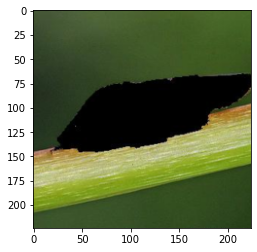

In [9]:
images, labels = next(iter(dataloaders["train"]))
im = np.asarray(images[0])
im = np.moveaxis(im, 0, -1)
print(im.shape)
print(dic[int(labels[0])])
plt.imshow(im)

# 2. Transfer Learning

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
model = models.resnet18(pretrained = True).to(device)

In [13]:
model.fc = nn.Sequential(
               nn.Linear(model.fc.in_features, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9)).to(device)

In [14]:
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

In [15]:
criterion = nn.CrossEntropyLoss()

In [16]:
optimizer = optim.Adam(model.fc.parameters())

### 2.1 Training

In [23]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for index, (inputs, labels) in enumerate(dataloaders[phase]):
                if index % 100 == 0:
                    print("Batch: ", index, "/", int(N[phase]/batchsize))
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss /N[phase]
            epoch_acc = running_corrects.double() / N[phase]

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [24]:
model_trained = train_model(model, criterion, optimizer, num_epochs=1)

Epoch 1/1
----------
Batch:  0 / 709
Batch:  100 / 709
Batch:  200 / 709
Batch:  300 / 709
Batch:  400 / 709
Batch:  500 / 709
Batch:  600 / 709
Batch:  700 / 709
train loss: 0.8140, acc: 0.7155
Batch:  0 / 65
test loss: 0.7947, acc: 0.7219


### 2.2 Testing on Original

In [25]:
original = datasets.ImageFolder('data/original/val', transform=transform)

In [26]:
original_loader =  torch.utils.data.DataLoader(original, batch_size=batchsize, shuffle=True)

In [34]:
N_or = len(original)

In [35]:
N_or

4185

(224, 224, 3)
carnivore


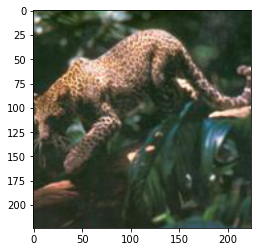

In [27]:
images, labels = next(iter(original_loader))
im = np.asarray(images[0])
im = np.moveaxis(im, 0, -1)
print(im.shape)
print(dic[int(labels[0])])
plt.imshow(im)

In [44]:
def test_model(model, loader, criterion):

    model.eval()

    running_loss = 0.0
    running_corrects = 0

    for index, (inputs, labels) in enumerate(loader):
        if index % 10 == 0:
            print("Batch: ", index, "/", int(N_or/batchsize))
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss = running_loss /N_or
    acc = running_corrects.double() / N_or

    print('loss: {:.4f}, acc: {:.4f}'.format(loss,
                                                acc))
    return (loss, acc)

In [45]:
or_loss, or_acc = test_model(model_trained, original_loader, criterion)

Batch:  0 / 65
Batch:  10 / 65
Batch:  20 / 65
Batch:  30 / 65
Batch:  40 / 65
Batch:  50 / 65
Batch:  60 / 65
loss: 0.3638, acc: 0.8879


## 3. My own model

In [23]:
from torchbearer import Trial
import torch.nn.functional as F

In [24]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

In [47]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, (31, 31), padding=0)
        self.conv2 = nn.Conv2d(10, 10, (16, 16), padding=0)
        self.conv3 = nn.Conv2d(10, 5, (3, 3), padding=2)
        self.fc1 = nn.Linear(2205, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 9)
    
    def forward(self, x):
        # YOUR CODE HERE
        out = self.conv1(x)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        
        out = self.conv2(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        
        
        out = self.conv3(out)
        out = F.relu(out)
        out = F.max_pool2d(out, (2,2))
        
        out = F.dropout(out, 0.2)
        
        out = out.view(out.shape[0], -1)
        
        
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        
        return out

In [48]:
model = CNN()
print(sum([i.numel() for i in model.parameters()]))

5626498


In [ ]:
#reset the data loaders
torch.manual_seed(seed)
# build the model
model = CNN()

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters())

device = "cuda:0" if torch.cuda.is_available() else "cpu"
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(dataloaders["train"], test_generator=dataloaders["test"])
trial.run(epochs=10)
results = trial.evaluate(data_key=torchbearer.TEST_DATA)
print(results)

#assert results['test_acc'] > 0.99


0/10(t):   0%|          | 0/710 [00:00<?, ?it/s]